New dataset from http://www.ece.k-state.edu/people/faculty/gjohnson/.

I want to try next things:

1) find correlation between all features: hour, month, ws, wd, temperature.

2) compare the datasets itselves: how the perfomance will increase.

3) refactor ARIMA model and try another time series forecasting techniques (e.g. LSTM).

http://publications.elia.be/Publications/Publications/WindForecasting.v4.svc/ExportForecastData?beginDate=2012-01-01T20%3A00%3A00.000Z&endDate=2012-12-31T20%3A00%3A00.000Z&isOffshore=&isEliaConnected=&region=2


col_names = ['Year', 'Month', 'Day',
             'Hour', 'Speed at 10m',
             'Speed at 40m', 'Direction',
             'Temperature']
raw_data = pd.read_csv('Downloads/elkriv04.csv', names=col_names)\
                                    .dropna().drop(columns='Year')
raw_data['Month'] = raw_data['Month'].apply(lambda x: list(calendar.month_abbr).index(x))

In [3]:
import pandas as pd
import numpy as np
import calendar
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from catboost import CatBoostRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error

I took data from Belgium system operator site. Data represents historical time-series of wind power generated in defined region. Specifically, I chose Vlandaaren region, coast region with represinting wind profile. The site doesn't have convinient form to download data, so I used GET HTTP requests to collect info on 1 year period. After that I downloaded detailed weather info from rp5.ru on Vlaandaren region. By merging these tables I achieved resulting dataset with weather as features and power output as labels.

In [279]:
power_data = pd.read_excel('Downloads/WindForecast_2015-01-01_2015-12-31-2.xls', header=3)
power_data = power_data.drop(columns=['Week-ahead Forecast [MW]',
                      'Day-ahead forecast (11h00) [MW]',
                      'Most recent forecast [MW]',
                      'Active Decremental Bids [yes/no]'])
power_data['DateTime'] = pd.to_datetime(power_data['DateTime'].apply(lambda x: x[3:6]+x[0:3]+x[6:]))
power_data = power_data.set_index(['DateTime'])

In [280]:
weather_data = pd.read_excel('Downloads/bruggewea.xls', header=6)

In [281]:
weather_data = weather_data.set_index(weather_data.columns[0])
weather_data['DD'] = weather_data['DD'].astype('category').cat.codes

In [282]:
weather_data = weather_data.drop(columns=['ff10','N','Cm','Ch',
                                          'VV','RRR','tR','E',
                                          'Tg',r"E'",'sss','WW',
                                          'W1','W2','Tn','Tx',
                                          'Cl','Nh','H', 'Pa'])

In [283]:
dataset = weather_data.merge(power_data, left_index=True, right_index=True, how='outer').dropna()

In [284]:
dataset['power'] = dataset['Measured & upscaled [MW]']/dataset['Monitored Capacity [MW]']

In [285]:
dataset.to_csv('data.csv')

---

Here I'm making some preprocessing to use data in machine learning algorithms.

In [138]:
dataset = pd.read_csv('data.csv')
dataset['Timestamp'] = pd.to_datetime(dataset['Unnamed: 0'])
label = dataset['Measured & upscaled [MW]']
dataset = dataset.drop(columns=['Unnamed: 0', 'Measured & upscaled [MW]', 'Monitored Capacity [MW]'])
dataset = dataset.set_index('Timestamp')

In [145]:
x_train, x_test, y_train, y_test = train_test_split(dataset.drop(columns='power'), dataset['power'],
                                                    test_size=0.1,
                                                    shuffle=True)
scale_x = MinMaxScaler()
scale_y = MinMaxScaler()
x_train = scale_x.fit_transform(x_train)
y_train = scale_y.fit_transform(y_train.values.reshape(-1,1))
x_test = scale_x.transform(x_test)
y_test = scale_y.transform(y_test.values.reshape(-1,1))

The first algo is catboost.

In [146]:
cat = CatBoostRegressor()

In [147]:
cat.fit(x_train, y=np.ravel(y_train), verbose=False)

In [148]:
y_pred = cat.predict(x_test)

In [149]:
np.sqrt(mean_squared_error(y_pred, y_test))

0.10904538614869477

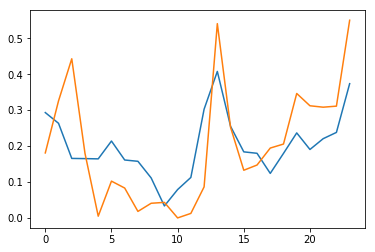

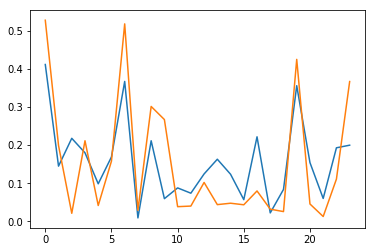

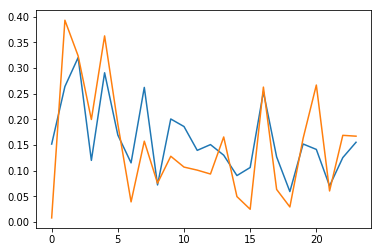

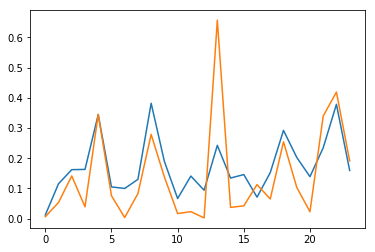

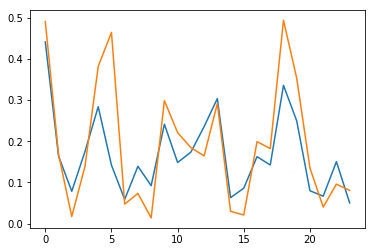

In [150]:
for i in range(5):
    plt.figure()
    plt.plot(y_pred[i*24:(i+1)*24])
    plt.plot(y_test[i*24:(i+1)*24])

In [151]:
np.sqrt(np.sum((y_pred-y_test.reshape(1,-1))**2)/y_pred.shape[0])

0.10904538614869477

In [12]:
svr = SVR()

In [13]:
svr.fit(x_train, np.ravel(y_train))

SVR(C=1.0, cache_size=200, coef0=0.0, degree=3, epsilon=0.1, gamma='auto',
  kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [14]:
svr_pred = svr.predict(x_test)

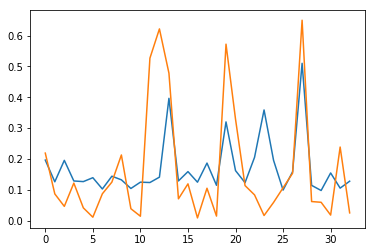

In [15]:
plt.plot(svr_pred[800:1000])
plt.plot(y_test[800:1000])

In [16]:
np.sum(np.sqrt((svr_pred-y_test.reshape(1,-1))**2))/svr_pred.shape[0]

0.11159058429213844

As you can see the algos give good results with 10% error.

---

Next step is to try an time-series forecasting approach. First algo is ARIMA

In [18]:
power_series = pd.DataFrame()

for year in range(2013,2018):
    power_data = pd.read_excel('Downloads/WindForecast_{0}-01-01_{0}-12-31.xls'.format(str(year)), header=3)
    power_data = power_data.drop(columns=['Week-ahead Forecast [MW]',
                          'Day-ahead forecast (11h00) [MW]',
                          'Most recent forecast [MW]',
                          'Active Decremental Bids [yes/no]'])
    power_data['DateTime'] = pd.to_datetime(power_data['DateTime'].apply(lambda x: x[3:6]+x[0:3]+x[6:]))
    power_data = power_data.set_index(['DateTime'])
    power_series = power_series.append(power_data)

In [19]:
power_series.to_csv('power_series.csv')

-----------

In [20]:
from statsmodels.tsa import seasonal

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/compat/pandas.py:56: FutureWarning: The pandas.core.datetools module is deprecated and will be removed in a future version. Please use the pandas.tseries module instead.
  from pandas.core import datetools


In [21]:
series = pd.read_csv('power_series.csv')
series['DateTime'] = pd.to_datetime(series['DateTime'])
series = series.set_index('DateTime')

In [22]:
x = series['Measured & upscaled [MW]'].values
x = x[~np.isnan(x)]

In [23]:
x = series.drop(columns='Monitored Capacity [MW]').resample('w').mean()

In [24]:
decomp = seasonal.seasonal_decompose(x)

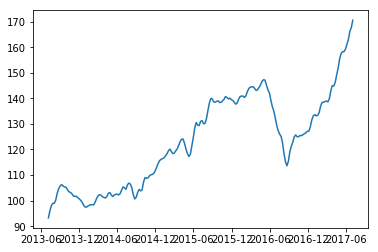

In [25]:
plt.plot(decomp.trend)

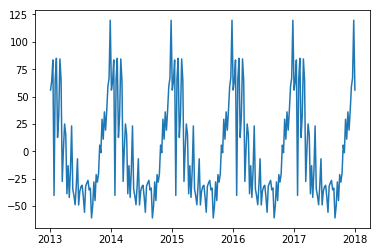

In [26]:
plt.plot(decomp.seasonal)

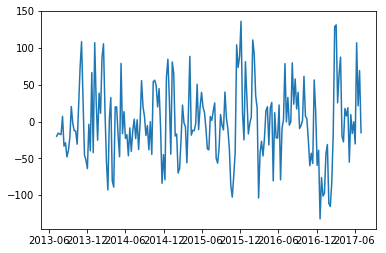

In [27]:
plt.plot(decomp.resid)

In [28]:
from statsmodels.tsa.arima_model import ARIMA

In [29]:
x[:240].shape

(240, 1)

In [31]:
#make it stationary
log_data = np.log(x)

In [37]:
log_dif = log_data - log_data.shift(periods=1)

In [133]:
model = ARIMA(log_data[:240], order=(3, 1, 1))  
results = model.fit(disp=-1)  

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:646: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):
/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:650: FutureWarning: Conversion of the second argument of issubdtype from `complex` to `np.complexfloating` is deprecated. In future, it will be treated as `np.complex128 == np.dtype(complex).type`.
  elif issubdtype(paramsdtype, complex):


/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


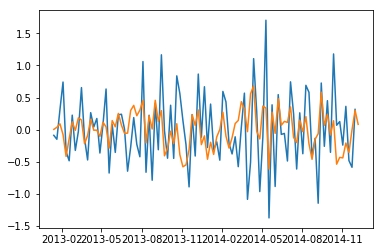

In [134]:
plt.plot(log_dif[:100], label='True differences')
plt.plot(results.fittedvalues[:100], label='Predictions')

In [135]:
model_val = pd.Series(log_data['Measured & upscaled [MW]'].iloc[0], index=log_data.index)

In [136]:
model_val  = model_val.add(pd.Series(results.fittedvalues, copy=True).cumsum()).dropna()

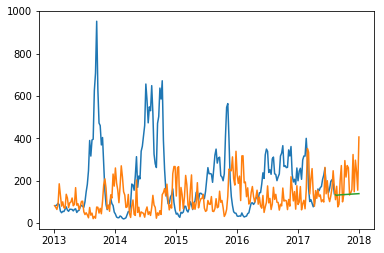

In [137]:
plt.plot(np.exp(model_val))
plt.plot(np.exp(log_data))
plt.plot(ARIMA_forecasts, label='ARIMA model predictions')

In [129]:
ARIMA_forecasts = results.predict(start='2017-08-13', end='2017-12-31')
ARIMA_forecasts = ARIMA_forecasts.cumsum()
ARIMA_forecasts = ARIMA_forecasts + model_val.iloc[-1]
ARIMA_forecasts = np.exp(ARIMA_forecasts)

/Library/Frameworks/Python.framework/Versions/3.6/lib/python3.6/site-packages/statsmodels/tsa/kalmanf/kalmanfilter.py:577: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  if issubdtype(paramsdtype, float):


In [130]:
np.sqrt(mean_squared_error(ARIMA_forecasts[:-20], x[240:-20]))

22.921428521655955

In [131]:
x[240:].shape

(21, 1)